# Rolling Regression

* [Pairs trading](https://www.quantopian.com/posts/pairs-trading-algorithm-1) is a famous technique in algorithmic trading that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GFI).

In [5]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd

import warnings

sampler_kwargs = {"cores": 4, "chains": 4, "draws": 250}

warnings.simplefilter('ignore')

RANDOM_SEED = 20090425

Lets load the prices of GFI and GLD.

In [6]:
prices = pd.read_csv(pm.get_data('stock_prices.csv')).dropna()
prices['Date'] = pd.DatetimeIndex(prices['Date'])
prices = prices.set_index('Date')
prices_zscored = (prices - prices.mean()) / prices.std()
prices.head()

,GFI,GLD
Date,,
2010-01-04,13.55,109.82
2010-01-05,13.51,109.88
2010-01-06,13.70,110.71
2010-01-07,13.63,111.07
2010-01-08,13.72,111.52


Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

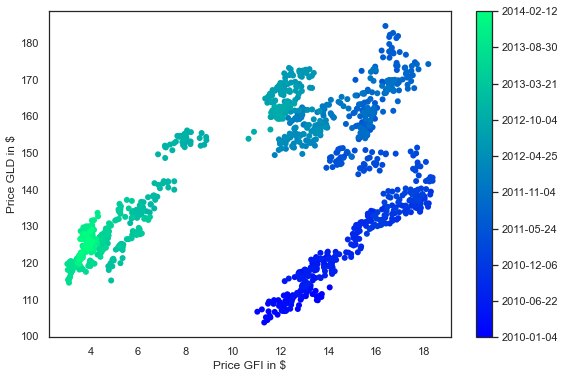

In [7]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$')
colors = np.linspace(0.1, 1, len(prices))
mymap = plt.get_cmap("winter")
sc = ax.scatter(prices.GFI, prices.GLD, c=colors, cmap=mymap, lw=0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);

## Rolling regression

Build a model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time. That idea is similar to the [stochastic volatility model](stochastic_volatility.ipynb).

$$ \alpha_t \sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2) $$
$$ \beta_t \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2) $$

In [9]:
with pm.Model() as model_randomwalk:
    # std of random walk
    sigma_alpha = pm.HalfNormal('sigma_alpha', 50.)
    sigma_beta = pm.HalfNormal('sigma_beta', 50.)
    
    alpha = pm.GaussianRandomWalk('alpha', sigma=sigma_alpha, 
                                  shape=len(prices))
    beta = pm.GaussianRandomWalk('beta', sigma=sigma_beta, 
                                 shape=len(prices))
    
    # Define regression
    regression = alpha + beta * prices_zscored.GFI
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sigma=sd, 
                           observed=prices_zscored.GLD)

Inference. Despite this being quite a complex model, NUTS handles it wells.

In [10]:
with model_randomwalk:
    trace_rw = pm.sample(tune=2000, cores=2, 
                         target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha, sigma_beta, sigma_alpha]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1275 seconds.
The acceptance probability does not match the target. It is 0.9688459839785662, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.838038555792336, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis of results

As can be seen below, $\alpha$, the intercept, changes over time.

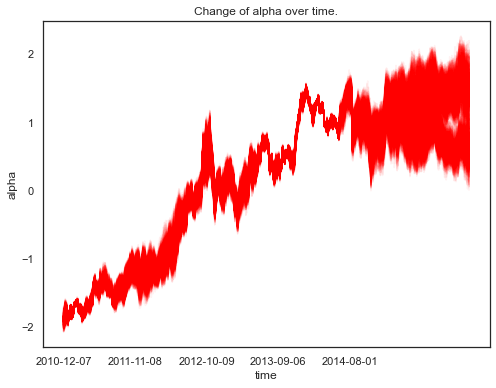

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='alpha', title='Change of alpha over time.')
ax.plot(trace_rw['alpha'].T, 'r', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

As does the slope.

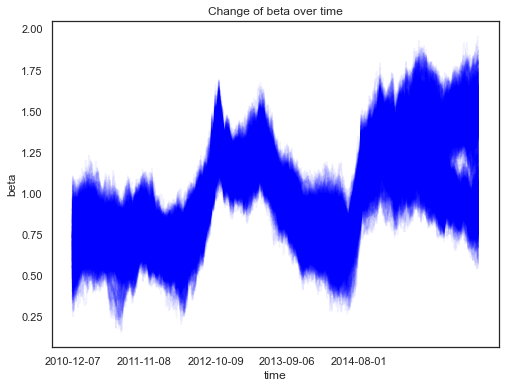

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='time', ylabel='beta', title='Change of beta over time')
ax.plot(trace_rw['beta'].T, 'b', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[::10]['alpha'].T))
mymap = plt.get_cmap('winter')
mymap_sc = plt.get_cmap('winter')

xi = np.linspace(prices_zscored.GFI.min(), prices_zscored.GFI.max(), 50)
for i, (alpha, beta) in enumerate(zip(trace_rw[::15]['alpha'].T, 
                                      trace_rw[::15]['beta'].T)):
    for a, b in zip(alpha[::30], beta[::30]):
        ax.plot(xi, a + b*xi, alpha=.01, lw=1, 
                c=mymap_sc(colors_sc[i]))
        
sc = ax.scatter(prices_zscored.GFI, prices_zscored.GLD, 
                label='data', cmap=mymap, c=colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices_zscored[::len(prices)//10].index]);
#ax.set(ylim=(100, 190));